## 1. 数据读取

In [1]:
import pandas as pd

df = pd.read_csv('house_info.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5417 entries, 0 to 5416
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    5417 non-null   object 
 1   follower_numbers         5417 non-null   int64  
 2   total_price              5417 non-null   float64
 3   unit_price               5417 non-null   int64  
 4   build_time               5417 non-null   object 
 5   region                   5417 non-null   object 
 6   house_type               5417 non-null   object 
 7   floor                    5417 non-null   object 
 8   house_area               5417 non-null   object 
 9   house_type_structure     5417 non-null   object 
 10  inside_area              5417 non-null   object 
 11  building_type            5417 non-null   object 
 12  orientation              5417 non-null   object 
 13  building_structure       5417 non-null   object 
 14  decoration              

## 2. 数据预处理

In [2]:
# 删除包含缺失值的列
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5108 entries, 0 to 5107
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    5108 non-null   object 
 1   follower_numbers         5108 non-null   int64  
 2   total_price              5108 non-null   float64
 3   unit_price               5108 non-null   int64  
 4   build_time               5108 non-null   object 
 5   region                   5108 non-null   object 
 6   house_type               5108 non-null   object 
 7   floor                    5108 non-null   object 
 8   house_area               5108 non-null   object 
 9   house_type_structure     5108 non-null   object 
 10  inside_area              5108 non-null   object 
 11  building_type            5108 non-null   object 
 12  orientation              5108 non-null   object 
 13  building_structure       5108 non-null   object 
 14  decoration              

In [3]:
# 提取floor楼层中的数字
df['floor'] = df['floor'].str.extract(r'(\d+)', expand=False).astype('int')
# 将房价面积由“85.99m²”-->“85.99”
df['house_area'] = df['house_area'].apply(lambda x: x[:-1]).astype('float')

# 将东湖高新划分到洪山，沌口开发区划分到汉南
df.loc[df['region'] == '东湖高新', 'region'] = '洪山'
df.loc[df['region'] == '沌口开发区', 'region'] = '汉南'
# 将region列中值后添加“区”，如“汉阳”-->“汉阳区”
df['region'] = df['region'] + '区'

In [4]:
# 数量、均值、标准差、最小值、四分之一分位数、二分之一分位数、四分之三分位数、最大值
df.describe()

,follower_numbers,total_price,unit_price,floor,house_area
count,5108.000000,5108.000000,5108.000000,5108.000000,5108.000000
mean,17.383125,184.584043,19364.369225,22.663665,94.957747
std,33.795215,102.628088,6980.271683,12.248154,30.513251
min,0.000000,22.000000,3092.000000,1.000000,19.710000
25%,1.000000,121.900000,15027.250000,11.000000,78.707500
50%,5.000000,164.800000,18433.500000,24.000000,90.520000
75%,21.000000,220.000000,22560.000000,33.000000,110.612500
max,676.000000,2000.000000,78570.000000,57.000000,526.320000


## 3. 武汉各区二手房数量条形图

In [5]:
import pyecharts.options as opts
from pyecharts.charts import Bar
from pyecharts.globals import ThemeType

region_list = df['region'].value_counts().index.tolist()
house_count_list = df['region'].value_counts().values.tolist()

c = Bar(init_opts=opts.InitOpts(theme=ThemeType.CHALK))
c.add_xaxis(region_list)
c.add_yaxis("武汉市", house_count_list)
c.set_global_opts(title_opts=opts.TitleOpts(title="武汉各区二手房数量柱状图", subtitle=""),
                                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(interval=0)))
c.render("./html/武汉各区二手房数量条形图.html")
c.render_notebook()

## 4. 武汉市各区房价分布2D地图

In [6]:
region_list = df['region'].value_counts().index.tolist()
median_unit_price = []
for region in region_list:
    median_unit_price.append(df.loc[df['region'] == region, 'unit_price'].median())

    
# 绘制2D地图
from pyecharts.charts import Map
# 加载武汉市地图数据
json_data = json.load(open('武汉市.json', encoding='utf-8'))

data_pair = [list(z) for z in zip(region_list, median_unit_price)]
    
text_style = opts.TextStyleOpts(color='#fff')
c = Map(init_opts=opts.InitOpts(width='1500px', height='700px', bg_color='#404a58'))    
c.add_js_funcs("echarts.registerMap('武汉市',{});".format(json_data))
c.add(series_name="武汉市", data_pair=data_pair, maptype="武汉市", label_opts=opts.LabelOpts(color='#fff'))
c.set_global_opts(legend_opts=opts.LegendOpts(textstyle_opts=text_style), 
                  title_opts=opts.TitleOpts(title="武汉", title_textstyle_opts=text_style)
                  ,visualmap_opts=opts.VisualMapOpts(split_number=6, max_=30000, range_text=['高', '低'], 
                                                     textstyle_opts=text_style))
c.render("./html/武汉市各区房价分布2D地图.html")
c.render_notebook()

## 5. 武汉市各区房价分布3D地图.html

In [7]:
from pyecharts.charts import Map3D
from pyecharts.globals import ChartType
from pyecharts.commons.utils import JsCode

json_region = []
json_center = []
for feature in json_data['features']:
    json_region.append(feature['properties']['name'])
    json_center.append(feature['properties']['center'])
data_pair = []

for region, center in zip(json_region, json_center):
    median_price = df.loc[df['region'] == region, 'unit_price'].median()
    data_pair.append((region, center + [median_price]))

    
# 绘制3D地图
c = Map3D(init_opts=opts.InitOpts(width='1500px', height='700px'))
    
c.add_js_funcs("echarts.registerMap('武汉市',{});".format(json_data))
c.add_schema(
    maptype='武汉市',
    itemstyle_opts=opts.ItemStyleOpts(
        color="rgb(5,101,123)",
        opacity=1,
        border_width=0.8,
        border_color="rgb(62,215,213)",
    ),
    map3d_label=opts.Map3DLabelOpts(
        is_show=False,
        formatter=JsCode("function(data){return data.name + " " + data.value[2];}"),
    ),
    emphasis_label_opts=opts.LabelOpts(
        is_show=False,
        color="#fff",
        font_size=10,
        background_color="rgba(0,23,11,0)",
    ),
    light_opts=opts.Map3DLightOpts(
        main_color="#fff",
        main_intensity=1.2,
        main_shadow_quality="high",
        is_main_shadow=False,
        main_beta=10,
        ambient_intensity=0.3,
    ),
)
c.add(
    series_name="武汉市",
    data_pair=data_pair,
    type_=ChartType.BAR3D,
    bar_size=1,
    shading="lambert",
    label_opts=opts.LabelOpts(
        is_show=False,
        formatter=JsCode("function(data){return data.name + ' ' + data.value[2];}"),
    )

)
c.set_global_opts(title_opts=opts.TitleOpts(title="武汉市各区房价分布3D地图.html"))

c.render("./html/武汉市各区房价分布3D地图.html")
c.render_notebook()

## 6. 武汉各区二手房单价箱型图

In [8]:
# 统计各个区二手房单价信息
unit_price_list = []
for region in region_list:
    unit_price_list.append(df.loc[df['region'] == region, 'unit_price'].values.tolist())


# 绘制箱型图
from pyecharts.charts import Boxplot

c = Boxplot(init_opts=opts.InitOpts(theme=ThemeType.CHALK))
c.add_xaxis(region_list)
c.add_yaxis("武汉市", c.prepare_data(unit_price_list))
c.set_global_opts(title_opts=opts.TitleOpts(title="武汉各区二手房单价箱型图"), 
                 xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(interval=0)))
c.render("./html/武汉各区二手房单价箱型图.html")
c.render_notebook()

## 7. 武汉二手房房屋面积

In [9]:
new_df = pd.DataFrame(df['house_area'])
area_df = new_df.apply(lambda x : pd.cut(x, list(range(0, 530, 20)), labels=[str(n - 20) + '-' + str(n) for n in range(20, 530, 20)]))
series = area_df['house_area'].value_counts()
series.sort_index(ascending=True, inplace=True)
area_list = series.index.tolist()    # 房屋面积列表
count_list = series.values.tolist()    # 该面积数量列表


from pyecharts.charts import Line

c = Bar(init_opts=opts.InitOpts(theme=ThemeType.CHALK))
c.add_xaxis(area_list)
c.add_yaxis("武汉市", count_list, yaxis_index=0)
c.set_global_opts(title_opts=opts.TitleOpts(title="武汉二手房房屋面积", subtitle=""),
                xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(interval=0, rotate=-60)))
c.render("./html/武汉二手房房屋面积.html")
c.render_notebook()

E:\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 38754 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 31215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24635 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\an

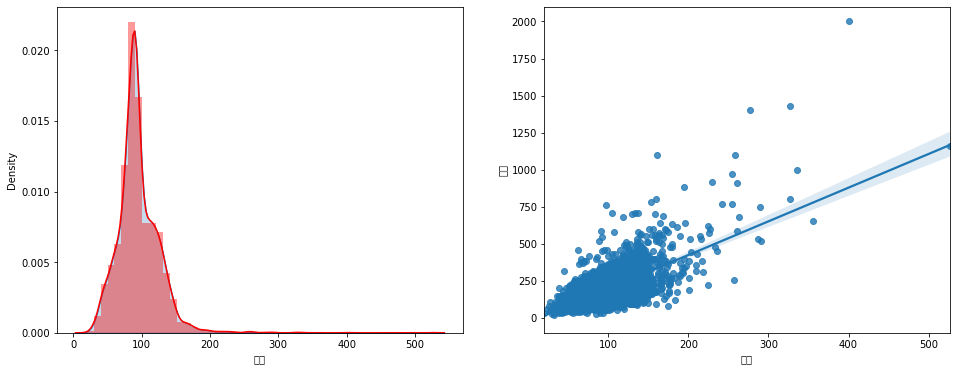

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

f, [ax1,ax2] = plt.subplots(1, 2, figsize=(16, 6))

# 房屋面积
sns.distplot(df['house_area'], ax=ax1, color='r')
sns.kdeplot(df['house_area'], shade=True, ax=ax1)
ax1.set_xlabel('面积')

# 房屋面积和价格的关系
sns.regplot(x='house_area', y='total_price', data=df, ax=ax2)
ax2.set_xlabel('面积')
ax2.set_ylabel('总价')

plt.show()

## 8. 二手房各区楼层与房价分布3D条形图

In [11]:
data = []
json_region = ['新洲区', '蔡甸区', '黄陂区', '汉南区', '东西湖区', '江夏区', '青山区', 
               '汉阳区','硚口区', '洪山区', '江岸区', '江汉区', '武昌区']

for region in json_region:
    detail_df = df.loc[df['region'] == region]
    new_df = pd.DataFrame(detail_df['floor'])
    detail_df['floor'] = new_df.apply(lambda x : pd.cut(x, list(range(0, 61, 5)), labels=[str(n - 5) + '-' + str(n) for n in range(5, 61, 5)]))
    floor_list = detail_df['floor'].value_counts().index.tolist()
    
    all_floor_list = [str(n - 5) + '-' + str(n) for n in range(5, 61, 5)]
    
    median_price_list = []    # 保存各区各楼层房价中位数
    for floor in floor_list:
        median_price = detail_df.loc[detail_df['floor'] == floor, 'unit_price'].median()
        median_price_list.append(median_price)
    
    # 遍历所有楼层
    for i in range(len(all_floor_list)):
        # 如果该楼层没有房价数据
        if all_floor_list[i] not in floor_list:
            data.append([json_region.index(region), i, 0])
        # 如果该楼层有房价数据
        else:
            data.append([json_region.index(region), i, median_price_list[floor_list.index(all_floor_list[i])]])

data = [[d[1], d[0], d[2]] for d in data]

# 绘制3D图
from pyecharts.charts import Bar3D
from pyecharts.globals import ThemeType

c = Bar3D(init_opts=opts.InitOpts(width="1500px", height="700px", theme=ThemeType.ROMANTIC))
        
c.add(
    series_name="",
    data=data,
    xaxis3d_opts=opts.Axis3DOpts(type_="category", data=all_floor_list),
    yaxis3d_opts=opts.Axis3DOpts(type_="category", data=json_region, interval=0),
    zaxis3d_opts=opts.Axis3DOpts(type_="value"),
)
c.set_global_opts(
    visualmap_opts=opts.VisualMapOpts(
        max_=30000,
        range_color=[
            "#313695",
            "#4575b4",
            "#74add1",
            "#abd9e9",
            "#e0f3f8",
            "#ffffbf",
            "#fee090",
            "#fdae61",
            "#f46d43",
            "#d73027",
            "#a50026",
        ],
    )
)
c.render("./html/二手房各区楼层与房价分布3D条形图.html")
c.render_notebook()

<ipython-input-11-84e83af90f92>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detail_df['floor'] = new_df.apply(lambda x : pd.cut(x, list(range(0, 61, 5)), labels=[str(n - 5) + '-' + str(n) for n in range(5, 61, 5)]))


## 9. 武汉二手房各户型横向条形图

In [12]:
series = df['house_type'].value_counts()
series.sort_index(ascending=False, inplace=True)
house_type_list = series.index.tolist()
count_list = series.values.tolist()

c = Bar(init_opts=opts.InitOpts(theme=ThemeType.CHALK))
c.add_xaxis(house_type_list)
c.add_yaxis("武汉市", count_list)
c.reversal_axis()
c.set_series_opts(label_opts=opts.LabelOpts(position="right"))
c.set_global_opts(title_opts=opts.TitleOpts(title="武汉二手房各户型横向条形图"),
                datazoom_opts=[opts.DataZoomOpts(yaxis_index=0, type_="slider", orient="vertical")],)
c.render("./html/武汉二手房各户型横向条形图.html")
c.render_notebook()

## 10. 武汉二手房房屋装修饼状图

In [13]:
decoration_list = df['decoration'].value_counts().index.tolist()
count_list = df['decoration'].value_counts().values.tolist()

from pyecharts.charts import Pie

c = Pie(init_opts=opts.InitOpts(theme=ThemeType.CHALK))
c.add(series_name="房屋装修",
        data_pair=[list(z) for z in zip(decoration_list, count_list)],
        rosetype="radius",
        radius="55%",
        center=["50%", "50%"],
        label_opts=opts.LabelOpts(is_show=False, position="center"))
c.set_global_opts(title_opts=opts.TitleOpts(
                  title="武汉二手房房屋装修饼状图",
                  pos_left="center",
                  pos_top="20",
                  title_textstyle_opts=opts.TextStyleOpts(color="#fff")),
                  legend_opts=opts.LegendOpts(is_show=False))
c.set_series_opts(tooltip_opts=opts.TooltipOpts(trigger="item", formatter="{a} <br/>{b}: {c} ({d}%)"),
                label_opts=opts.LabelOpts(color="rgba(255, 255, 255, 255)"))
c.render("./html/武汉二手房房屋装修饼状图.html")
c.render_notebook()

## 11. 武汉二手房有无电梯与房价关系图

In [14]:
df['elevator'].value_counts()
true_elevator_count = []    # 各区有电梯数量占比
false_elevator_count = []    # 各区无电梯数量占比
true_elevator_price = []    # 各区有电梯单价中位数
false_elevator_price = []    # 各区无电梯单价中位数
elevator_df = df.loc[df['elevator'] != '暂无数据']
for region in region_list:
    detail_df = elevator_df.loc[df['region'] == region]
    count_list = detail_df['elevator'].value_counts().values.tolist()
    ratio_list = [round(count / sum(count_list), 2) for count in count_list]
    true_elevator_count.append(ratio_list[0])
    false_elevator_count.append(ratio_list[1])
    true_elevator_price.append(detail_df.loc[detail_df['elevator'] == '有', 'unit_price'].median())
    false_elevator_price.append(detail_df.loc[detail_df['elevator'] == '无', 'unit_price'].median())
    

# 绘制关系图
from pyecharts.charts import Grid, Line

bar = (
    Bar()
    .add_xaxis(region_list)
    .add_yaxis(
        "有电梯",
        true_elevator_count,
        yaxis_index=1,
    )
    .add_yaxis(
        "无电梯",
        false_elevator_count,
        yaxis_index=1,
    )
    .extend_axis(
        yaxis=opts.AxisOpts(
            type_="value",
            name="数量占比",
            min_=0,
            max_=3,
            position="left",
            axisline_opts=opts.AxisLineOpts(
                linestyle_opts=opts.LineStyleOpts(color="#d14a61")
            ),
            splitline_opts=opts.SplitLineOpts(
                is_show=True, linestyle_opts=opts.LineStyleOpts(opacity=1)
            ),
        )
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            name="单价",
            min_=0,
            max_=30000,
            position="right",
            offset=0,
            axisline_opts=opts.AxisLineOpts(
                linestyle_opts=opts.LineStyleOpts(color="#5793f3")
            ),
            axislabel_opts=opts.LabelOpts(formatter="{value} 元/m²"),
        ),
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(interval=0)),
        title_opts=opts.TitleOpts(title="武汉二手房有无电梯与房价关系图"),
        tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross"),
    )
)

line = (
    Line()
    .add_xaxis(region_list)
    .add_yaxis(
        "有电梯",
        true_elevator_price,
        yaxis_index=0,
        label_opts=opts.LabelOpts(is_show=True),
    )
    .add_yaxis(
        "无电梯",
        false_elevator_price,
        yaxis_index=0,
        label_opts=opts.LabelOpts(is_show=True),
    )
)

bar.overlap(line)
grid = Grid(init_opts=opts.InitOpts(theme=ThemeType.CHALK))
grid.add(bar, opts.GridOpts(pos_left="5%", pos_right="20%"), is_control_axis_index=True)
grid.render('./html/武汉二手房有无电梯与房价关系图1.html')
grid.render_notebook()

In [15]:
bar = (
    Bar()
    .add_xaxis(region_list)
    .add_yaxis("有电梯", true_elevator_count)
    .add_yaxis("无电梯", false_elevator_count)
    .set_global_opts(title_opts=opts.TitleOpts(title="武汉二手房有无电梯数量占比柱状图"))
)
line = (
    Line()
    .add_xaxis(region_list)
    .add_yaxis("有电梯", true_elevator_price)
    .add_yaxis("无电梯", false_elevator_price)
    .set_global_opts(
        title_opts=opts.TitleOpts(title="武汉二手房有无电梯与房价关系折线图", pos_top="48%"),
        legend_opts=opts.LegendOpts(pos_top="48%"),
        yaxis_opts=opts.AxisOpts(
            axislabel_opts=opts.LabelOpts(formatter="{value} 元/m²"),
        ),
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(interval=0)),
    )
)

grid = (
    Grid(init_opts=opts.InitOpts(theme=ThemeType.CHALK))
    .add(bar, grid_opts=opts.GridOpts(pos_bottom="60%"))
    .add(line, grid_opts=opts.GridOpts(pos_top="60%"))

)
grid.render("./html/武汉二手房有无电梯与房价关系图2.html")
grid.render_notebook()

## 12. 武汉热门二手房标签漏斗图

In [16]:
from collections import Counter

# 只统计关注人数超过三人的热门二手房
detail_df = df.loc[df['follower_numbers'] > 3]
label_list = []
for house_label in detail_df['house_label'].values.tolist():
    label_list += house_label.split(',')
label_and_count = Counter(label_list)
label_and_count = label_and_count.most_common()

from pyecharts.charts import Funnel

c = Funnel(init_opts=opts.InitOpts(theme=ThemeType.CHALK))
c.add("商品", [list(z) for z in label_and_count])
c.set_global_opts(title_opts=opts.TitleOpts(title="热门标签漏斗图"))
c.render("./html/武汉热门二手房标签漏斗图.html")
c.render_notebook()

## 13. 武汉热门二手房标题关键词

In [17]:
def load_stopwords(read_path):
    '''
    读取文件每行内容并保存到列表中
    :param read_path: 待读取文件的路径
    :return: 保存文件每行信息的列表
    '''
    result = []
    with open(read_path, "r", encoding='utf-8') as f:
        for line in f.readlines():
            line = line.strip('\n')  # 去掉列表中每一个元素的换行符
            result.append(line)
    return result

# 加载中文停用词
stopwords = load_stopwords('wordcloud_stopwords.txt')

In [18]:
import jieba

# 添加自定义词典
jieba.load_userdict("自定义词典.txt")

token_list = []
# 对标题内容进行分词，并将分词结果保存在列表中
for title in detail_df['title']:
    tokens = jieba.lcut(title, cut_all=False)
    token_list += [token for token in tokens if token not in stopwords]
len(token_list)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\pc\AppData\Local\Temp\jieba.cache
Loading model cost 1.101 seconds.
Prefix dict has been built successfully.


29065

In [19]:
from pyecharts.charts import WordCloud
from collections import Counter

token_count_list = Counter(token_list).most_common(100)
new_token_list = []
for token, count in token_count_list:
    new_token_list.append((token, str(count)))

c = WordCloud()   
c.add(series_name="热词", data_pair=new_token_list, word_size_range=[20, 200])
c.set_global_opts(
    title_opts=opts.TitleOpts(
        title="武汉热门二手房标题关键词", title_textstyle_opts=opts.TextStyleOpts(font_size=23)
    ),
    tooltip_opts=opts.TooltipOpts(is_show=True),
)
c.render("./html/武汉热门二手房标题关键词.html")
c.render_notebook()